<a href="https://colab.research.google.com/github/ravichoudharyds/Natural-Language-Processing/blob/master/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4: Conversation Modeling and decoding

# Part 1 Modeling

## 1.1 Attention visulization

In [0]:
### set up the model and complete the corresponding task

### the pretrained model was trained in ~2 hours, i.e. you can expect attention maps
### to look quite 'hard' (less soft spreading) i.e. attending to some particular token in the input

import re
from collections import Counter
from tqdm import tqdm
import json
from torch.utils.data import Dataset, DataLoader
import torch

RETOK = re.compile(r'\w+|[^\w\s]|\n', re.UNICODE)

class ChatDictionary(object):
    """
    Simple dict loader
    """
    def __init__(self, dict_file_path):
        self.word2ind = {}  # word:index
        self.ind2word = {}  # index:word
        self.counts = {}  # word:count

        dict_raw = open(dict_file_path, 'r').readlines()
        
        for i, w in enumerate(dict_raw):
            _word, _count = w.strip().split('\t')
            if _word == '\\n':
                _word = '\n'
            self.word2ind[_word] = i
            self.ind2word[i] = _word
            self.counts[_word] = _count
            
    def t2v(self, tokenized_text):
        return [self.word2ind[w] if w in self.counts else self.word2ind['__unk__'] for w in tokenized_text]

    def v2t(self, list_ids):
        return ' '.join([self.ind2word[i] for i in list_ids])
    
    def pred2text(self, tensor):
        result = []
        for i in range(tensor.size(0)):
            if tensor[i].item() == '__end__'  or tensor[i].item() == '__null__':  # null is pad
                break
            else:
                result.append(self.ind2word[tensor[i].item()])
        return ' '.join(result)
    
    def __len__(self):
        return len(self.counts)

In [0]:
class ChatDataset(Dataset):
    """
    Json dataset wrapper
    """
    
    def __init__(self, dataset_file_path, dictionary, dt='train'):
        super().__init__()
        
        json_text = open(dataset_file_path, 'r').readlines()
        self.samples = []
        
        for sample in tqdm(json_text):
            sample = sample.rstrip()
            sample = json.loads(sample)
            _inp_toked = RETOK.findall(sample['text'])
            _inp_toked_id = dictionary.t2v(_inp_toked)

            sample['text_vec'] = torch.tensor(_inp_toked_id, dtype=torch.long)
            
            # train and valid have different key names for target
            if dt == 'train':
                _tar_toked = RETOK.findall(sample['labels'][0]) + ['__end__']
            elif dt == 'valid':
                _tar_toked = RETOK.findall(sample['eval_labels'][0]) + ['__end__']
                
            _tar_toked_id = dictionary.t2v(_tar_toked)
            
            sample['target_vec'] = torch.tensor(_tar_toked_id, dtype=torch.long)
            
            self.samples.append(sample)
            
    def __getitem__(self, i):
        return self.samples[i]['text_vec'], self.samples[i]['target_vec']
    
    def __len__(self):
        return len(self.samples)

In [0]:
def pad_tensor(tensors, sort=True, pad_token=0):
    rows = len(tensors)
    lengths = [len(i) for i in tensors]
    max_t = max(lengths)
        
    output = tensors[0].new(rows, max_t)
    output.fill_(pad_token)  # 0 is a pad token here
    
    for i, (tensor, length) in enumerate(zip(tensors, lengths)):
        output[i,:length] = tensor

    return output, lengths

def argsort(keys, *lists, descending=False):
    """Reorder each list in lists by the (descending) sorted order of keys.
    :param iter keys: Keys to order by.
    :param list[list] lists: Lists to reordered by keys's order.
                             Correctly handles lists and 1-D tensors.
    :param bool descending: Use descending order if true.
    :returns: The reordered items.
    """
    ind_sorted = sorted(range(len(keys)), key=lambda k: keys[k])
    if descending:
        ind_sorted = list(reversed(ind_sorted))
    output = []
    for lst in lists:
        if isinstance(lst, torch.Tensor):
            output.append(lst[ind_sorted])
        else:
            output.append([lst[i] for i in ind_sorted])
    return output

def batchify(batch):
    inputs = [i[0] for i in batch]
    labels = [i[1] for i in batch]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)

    return {
        "text_vecs": input_vecs,
        "text_lens": input_lens,
        "target_vecs": label_vecs,
        "target_lens": label_lens,
        'use_packed': True
    }

In [0]:
# loading datasets and dictionary

# downloading pretrained models and data

### DOWNLOADING THE FILES
import os

### persona chat dataset
if not os.path.exists('./dict'):
    !wget "https://nyu.box.com/shared/static/sj9f87tofpicll89xbc154pmbztu5q4h" -O './dict'
if not os.path.exists('./train.jsonl'):
    !wget "https://nyu.box.com/shared/static/aqp0jyjaixjmukm5asasivq2bcfze075.jsonl" -O './train.jsonl'
if not os.path.exists('./valid.jsonl'):
    !wget "https://nyu.box.com/shared/static/eg4ivddtqib2hkf1k8rkxnmzmo0cq27p.jsonl" -O './valid.jsonl'

if not os.path.exists('./chat_model_best_22.pt'):
    !wget "https://nyu.box.com/shared/static/24zsynuks8nzg7530tgakzh8o62id9xa.pt" -O './chat_model_best_22.pt'

chat_dict = ChatDictionary('./dict')
train_dataset = ChatDataset('./train.jsonl', chat_dict)
valid_dataset = ChatDataset('./valid.jsonl', chat_dict, 'valid')

100%|██████████| 7801/7801 [00:00<00:00, 7847.49it/s]


In [0]:
train_loader = DataLoader(train_dataset, shuffle=True, collate_fn=batchify, batch_size=256)
valid_loader = DataLoader(valid_dataset, shuffle=False, collate_fn=batchify, batch_size=256)

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class EncoderRNN(nn.Module):
    """Encodes the input context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, pad_idx=0, dropout=0, shared_lt=None):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        self.pad_idx = pad_idx
        
        if shared_lt is None:
            self.embedding = nn.Embedding(self.vocab_size, self.embed_size, pad_idx)
        else:
            self.embedding = shared_lt
            
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        
    def forward(self, text_vec, text_lens, hidden=None, use_packed=True):
        embedded = self.embedding(text_vec)
        attention_mask = text_vec.ne(self.pad_idx)

        embedded = self.dropout(embedded)
        if use_packed is True:
            embedded = pack_padded_sequence(embedded, text_lens, batch_first=True)
        output, hidden = self.gru(embedded, hidden)
        if use_packed is True:
            output, output_lens = pad_packed_sequence(output, batch_first=True)
        
        return output, hidden, attention_mask

    
class DecoderRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        decoder_hidden = decoder_hidden
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_output, attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_output, encoder_hidden, attention_mask = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_hidden, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log
    
    
class AttentionLayer(nn.Module):

    def __init__(self, hidden_size, embedding_size):
        super().__init__()
        input_dim = hidden_size

        self.linear_out = nn.Linear(hidden_size+input_dim, input_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)
        self.tanh = nn.Tanh()

    def forward(self, decoder_output, decoder_hidden, encoder_output, attention_mask):

        batch_size, seq_length, hidden_size = encoder_output.size()

        encoder_output_t = encoder_output.transpose(1,2)
        
        attention_scores = torch.bmm(decoder_output, encoder_output_t).squeeze(1)

        attention_scores.masked_fill_((~attention_mask), -10e5)
        attention_weights = self.softmax(attention_scores)

        mix = torch.bmm(attention_weights.unsqueeze(1), encoder_output)

        combined = torch.cat((decoder_output.squeeze(1), mix.squeeze(1)), dim=1)

        output = self.linear_out(combined).unsqueeze(1)
        output = self.tanh(output)

        return output, attention_weights
    
    
class seq2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout'],
                                    shared_lt=self.decoder.embedding
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('./chat_model_best_22.pt')
    else:
        model_pt = torch.load('./chat_model_best_22.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model = seq2seq(opts)
    model.load_state_dict(model_pt['state_dict'])
    model.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 256
    opts['num_layers_enc'] = 2
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.3
    opts['encoder_shared_lt'] = True

    model = seq2seq(opts)
    model.to(current_device)

In [0]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
import matplotlib.ticker as ticker
%matplotlib inline

def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize = (18,5))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone', aspect='auto')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') , rotation=90, fontsize=10)
    ax.set_yticklabels([''] + output_words.split(' '), fontsize=10);
  
    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [0]:
import numpy as np
len_vec = []
for text_vec, target_vec in valid_dataset:
    len_vec.append(len(text_vec))

np.argsort(len_vec)[100:105]

array([ 758, 4276, 6972, 4745,  425])

### You present here:

Input
your persona : i work from home . 
 your persona : i watch too much tv in spare time . 
 your persona : i like to spend my money on cars . 
 your persona : i ' ve never had a steady relationship . 
 hi how are you today 
 i ' m doing well how about you ? 
 doing good just waiting on the baby birth 
 aww congratulations . it must be exciting . 
 we are having triplets so very excited
Target
ow wow now that will be hard task __end__
Attention Maps


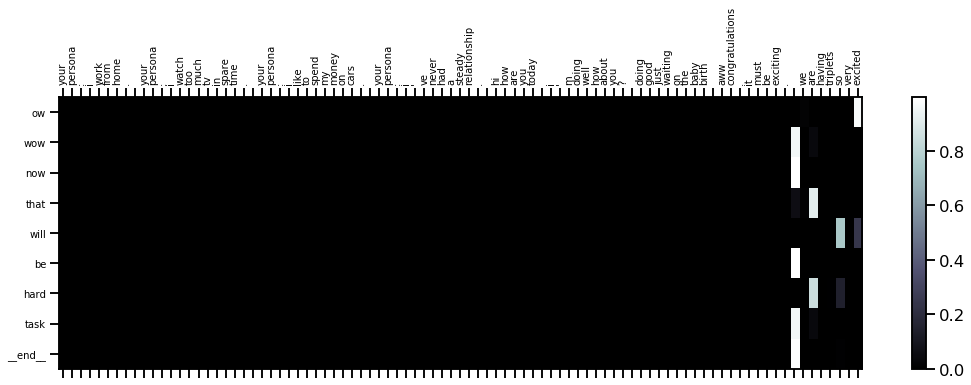

Input
your persona : i love to drink fancy tea . 
 your persona : i have a big library at home . 
 your persona : i ' m a museum tour guide . 
 your persona : i ' m partly deaf . 
 hi how are you doing ? i am okay how about you ? 
 i am doing good . just sipping tea . what do you do for work ? 
 i used to do home health aide but now i am disabled .
Target
i am sorry to hear that . what happened __end__
Attention Maps


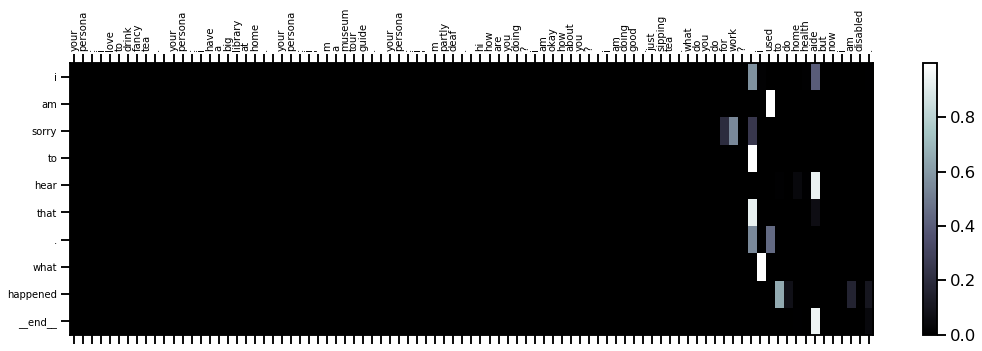

Input
your persona : my mother is a dentist . 
 your persona : my favourite artist is travis scott . 
 your persona : i like playing basketball . 
 your persona : i ' m currently looking for a job preferably at a restaurant . 
 hi ! i don ' t like the color orange . 
 hello . i like to shoot hoops , so orange balls are good with me . 
 that ' s amazing . i like dancing on weekends . you ?
Target
right now i am applying for jobs , i want to work in a restaurant . __end__
Attention Maps


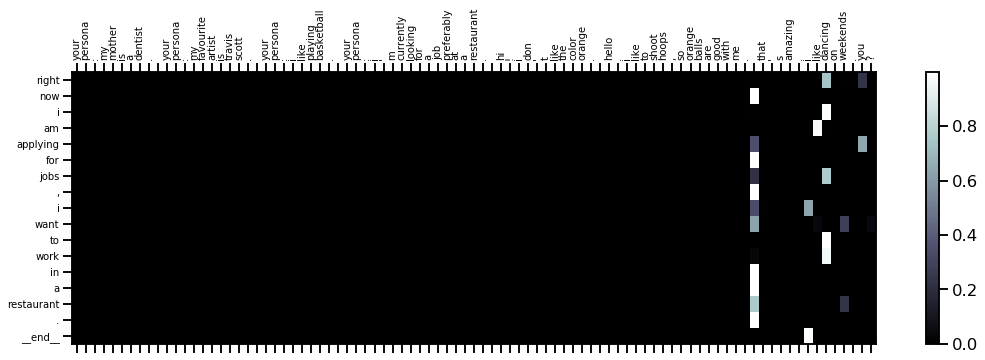

Input
your persona : my boyfriend and i are moving into an apartment together next week . 
 your persona : my favorite colors are red and silver . 
 your persona : i ' m fluent in english spanish and french . 
 your persona : i ' m an elementary school teacher . 
 hello how are you ? 
 hi . good . i am just picking out paint for my new apartment with my boyfriend . 
 sounds like a good way to end the weekend
Target
yeah . he won ' t go for red even though i love it . what is your favorite color ? __end__
Attention Maps


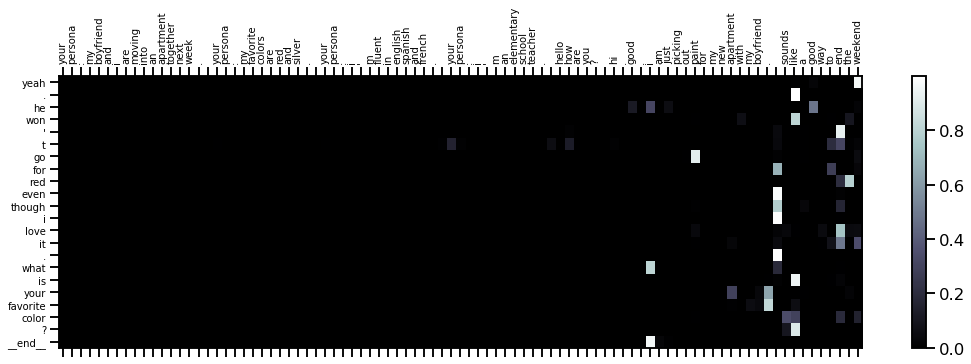

Input
your persona : i live in colorado . 
 your persona : i am a mechanical engineer . 
 your persona : i like to go hiking in the spring . 
 your persona : my favorite activity is rock climbing . 
 your persona : i have a black lab named trooper . 
 hi there , do you love taylor swift ? 
 you know it . i wish it was still summer . 
 not me , i ' m ready for the cuddle weather .
Target
cool ! i love to go rock climbing my fav summer activity . __end__
Attention Maps


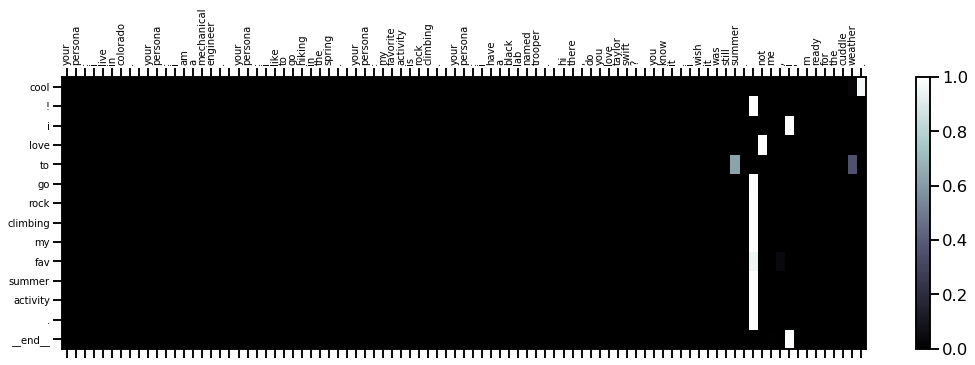

In [0]:
# this is some example attention map here, 
# *make sure you add text tokens on the axes to make it readable!*

for i in [883,   23, 5257, 1376, 1556]:
    inputs = [valid_dataset[i][0]]
    labels = [valid_dataset[i][1]]
    
    input_vecs, input_lens = pad_tensor(inputs)
    label_vecs, label_lens = pad_tensor(labels)
    
    # sort only wrt inputs here for encoder packinng
    input_vecs, input_lens, label_vecs, label_lens = argsort(input_lens, input_vecs, input_lens, label_vecs, label_lens, descending=True)
    model.eval()
    text_vecs = input_vecs.to('cuda')
    target_vecs = label_vecs.to('cuda')
    
    encoded = model.encoder(text_vecs, input_lens, use_packed=True)        
    decoder_output, preds, attn_w_log = model.decoder.decode_forced(target_vecs, encoded, label_lens)
    attn_w_log = [attn.clone().detach().cpu().numpy() for attn in attn_w_log]
    attn_w_log = np.concatenate(attn_w_log)
    print('Input')
    print(chat_dict.v2t(input_vecs[0].tolist()))
    print('Target')
    print(chat_dict.v2t(label_vecs[0].tolist()))
    print('Attention Maps')
    showAttention(chat_dict.v2t(input_vecs[0].cpu().numpy().tolist()),chat_dict.v2t(label_vecs[0].cpu().numpy().tolist()),attn_w_log)

![Imgur](https://i.imgur.com/xodciCU.png)

## 1.2 Encoder Transformer

In [0]:
### add transformer encoder as optional encoder in seq2seq model.

# code below can help you to start it, but feel free to start from scratch

from torch.nn import TransformerEncoder, TransformerEncoderLayer
import math

class EncoderTransformer(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers = 1, pad_idx = 0, dropout=0, max_len = 5000):
        super(EncoderTransformer, self).__init__()
        # self.pos_encoder = PositionalEncoding(ninp, dropout)
        self.pos_encoder = nn.Embedding(max_len, ninp, pad_idx)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp, pad_idx)
        self.ninp = ninp
        self.pad_idx = pad_idx
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):
        mask = src.eq(self.pad_idx)
        src = self.encoder(src)
        src = self.dropout(src) + self.dropout(self.pos_encoder(torch.arange(src.shape[1]).to('cuda')).unsqueeze(0))
        output = self.transformer_encoder(src.transpose(0,1), src_key_padding_mask = mask)
        return output, mask

class DecoderTransformerRNN(nn.Module):
    """Generates a sequence of tokens in response to context."""

    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = nn.Dropout(p=dropout)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embed_size, 0)
        
        self.gru = nn.GRU(
            self.embed_size, self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0,
        )
        
        self.attention = AttentionLayer(self.hidden_size, self.embed_size)

        self.out = nn.Linear(self.hidden_size, self.vocab_size)
        self.longest_label = 100

    def forward(self, text_vec, decoder_hidden, encoder_states):
        emb = self.embedding(text_vec)
        emb = self.dropout(emb)
        seqlen = text_vec.size(1)
        encoder_hidden, attention_mask = encoder_states
        
        output = []
        attn_w_log = []

        for i in range(seqlen):
            decoder_output, decoder_hidden = self.gru(emb[:,i,:].unsqueeze(1), decoder_hidden)
            
            # compute attention at each time step
            decoder_output_attended, attn_weights = self.attention(decoder_output, decoder_hidden, encoder_hidden.transpose(0,1), ~attention_mask)
            output.append(decoder_output_attended)
            attn_w_log.append(attn_weights)
            
        output = torch.cat(output, dim=1).to(text_vec.device)
        scores = self.out(output)
        
        return scores, decoder_hidden, attn_w_log
    
    def decode_forced(self, ys, encoder_states, xs_lens):
        encoder_hidden, _ = encoder_states
        
        batch_size = ys.size(0)
        target_length = ys.size(1)
        longest_label = max(target_length, self.longest_label)
        
        starts = torch.Tensor([1]).long().to(self.embedding.weight.device).expand(batch_size, 1).long()  # expand to batch size
        
        # Teacher forcing: Feed the target as the next input
        y_in = ys.narrow(1, 0, ys.size(1) - 1)
        decoder_input = torch.cat([starts, y_in], 1)
        len_vecs = torch.Tensor(xs_lens).unsqueeze(1).to('cuda')
        encoder_output = torch.sum(encoder_hidden,dim=0)/len_vecs
        if self.num_layers > 1:
            tensor_list = [encoder_output for i in range(self.num_layers)]
            encoder_output = torch.stack(tensor_list)
        else:
            encoder_output = encoder_output.unsqueeze(0)
        decoder_output, decoder_hidden, attn_w_log = self.forward(decoder_input, encoder_output, encoder_states)
        _, preds = decoder_output.max(dim=2)
        
        return decoder_output, preds, attn_w_log


In [0]:
class Transformer2seq(nn.Module):
    """
    Generic seq2seq model with attention mechanism.
    """
    def __init__(self, opts):

        super().__init__()
        self.opts = opts
        
        self.decoder = DecoderTransformerRNN(
                                    vocab_size=self.opts['vocab_size'],
                                    embed_size=self.opts['embedding_size'],
                                    hidden_size=self.opts['hidden_size'],
                                    num_layers=self.opts['num_layers_dec'],
                                    dropout=self.opts['dropout'],
                                )
        
        self.encoder = EncoderTransformer(
                                    ntoken = self.opts['vocab_size'],
                                    ninp = self.opts['embedding_size'],
                                    nhead = 4,
                                    nhid = 1024,
                                    nlayers=self.opts['num_layers_enc'],
                                    dropout=self.opts['dropout']
        )
        
    def train(self):
        self.encoder.train()
        self.decoder.train()
        
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'

load_pretrained = True
    
if load_pretrained is True:
    if current_device == 'cuda':
        model_pt = torch.load('/content/drive/My Drive/NLP_HW/HW4/transformer_model_best_12.pt')
    else:
        model_pt = torch.load('/content/drive/My Drive/NLP_HW/HW4/transformer_model_best_12.pt', map_location=torch.device('cpu'))
    opts = model_pt['opts']
    
    model_t = Transformer2seq(opts)
    model_t.load_state_dict(model_pt['state_dict'])
    model_t.to(current_device)
    
else:
    
    opts = {}

    opts['vocab_size'] = len(chat_dict)
    opts['hidden_size'] = 512
    opts['embedding_size'] = 512
    opts['num_layers_enc'] = 1
    opts['num_layers_dec'] = 2
    opts['dropout'] = 0.2

    model_t = Transformer2seq(opts)
    model_t.to(current_device)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index=0, reduction='sum')
optimizer = torch.optim.Adam(model_t.parameters(), 0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=0.01)

In [0]:
def val_loss_cal(model_t, criterion, valid_loader):
    val_loss = 0
    val_tokens = 0
    for i, batch in enumerate(valid_loader):
        model_t.eval()
        
        text_vecs = batch['text_vecs'].to('cuda')
        target_vecs = batch['target_vecs'].to('cuda')        
        encoded = model_t.encoder(text_vecs)
        decoder_output, preds, attn_w_log = model_t.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
        
        scores = decoder_output.view(-1, decoder_output.size(-1))
        
        loss = criterion(scores, target_vecs.view(-1))
        
        num_tokens = target_vecs.ne(0).long().sum().item()
        
        val_tokens += num_tokens
        val_loss += loss.item()
    return val_loss/val_tokens


def train_model(model_t, criterion, optimizer, scheduler, train_loader, valid_loader):
    best_val_loss = 100
    plot_cache = []
    for epoch in range(15):
        
        model_t.train()
        sum_loss = 0
        sum_tokens = 0
        
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            
            text_vecs = batch['text_vecs'].to('cuda')
            target_vecs = batch['target_vecs'].to('cuda')

            encoded = model_t.encoder(text_vecs)

            decoder_output, preds, attn_w_log = model_t.decoder.decode_forced(target_vecs, encoded, batch['text_lens'])
            
            scores = decoder_output.view(-1, decoder_output.size(-1))
            
            loss = criterion(scores, target_vecs.view(-1))
            
            num_tokens = target_vecs.ne(0).long().sum().item()
            sum_loss += loss.item()
            loss /= num_tokens
            
            loss.backward()
            optimizer.step()

            sum_tokens += num_tokens
            
            if i % 100 == 0:
                avg_train_loss = sum_loss/sum_tokens
                print("iter {} train loss = {}".format(i, sum_loss/sum_tokens))
        
        avg_val_loss = val_loss_cal(model_t, criterion, valid_loader)
        scheduler.step(avg_val_loss)
        torch.cuda.empty_cache()
        print("Epoch {} valid loss = {}".format(epoch, avg_val_loss))
        
        plot_cache.append( (avg_train_loss, avg_val_loss) )
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            
            torch.save({
            'state_dict': model_t.state_dict(),
            'opts': opts,
            'plot_cache': plot_cache,
                }, f'/content/drive/My Drive/NLP_HW/HW4/transformer_model_best_{epoch}.pt')

In [0]:
if load_pretrained == False:
    train_model(model_t, criterion, optimizer, scheduler, train_loader, valid_loader)

iter 0 train loss = 9.865202121559633
iter 100 train loss = 5.49315491670464
iter 200 train loss = 4.957746114920842
iter 300 train loss = 4.680779240990056
iter 400 train loss = 4.505083266382835
iter 500 train loss = 4.385324989754699
Epoch 0 valid loss = 3.9174496247979143
iter 0 train loss = 3.832870188248388
iter 100 train loss = 3.7565389202753243
iter 200 train loss = 3.7425548022260364
iter 300 train loss = 3.72905056850956
iter 400 train loss = 3.7172565043344723
iter 500 train loss = 3.707505307122067
Epoch 1 valid loss = 3.778212490038351
iter 0 train loss = 3.63820403476931
iter 100 train loss = 3.53257151163063
iter 200 train loss = 3.525711392576863
iter 300 train loss = 3.527407852998816
iter 400 train loss = 3.524295914253003
iter 500 train loss = 3.5222466588223194
Epoch 2 valid loss = 3.7171464616854117
iter 0 train loss = 3.4522680165816326
iter 100 train loss = 3.3867495379989445
iter 200 train loss = 3.3915480879841127
iter 300 train loss = 3.3931425461940954
iter 

## You present here:

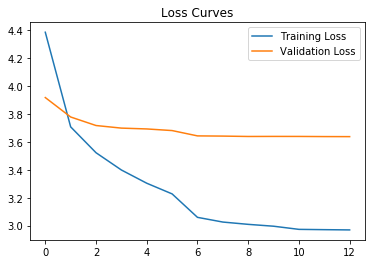

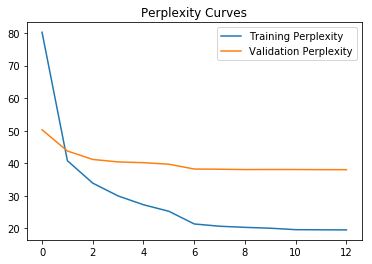

In [0]:
# check pdf to see what you expected to present
import matplotlib.pyplot as plt
import numpy as np

loss = model_pt['plot_cache']
train_loss = [loss[i][0] for i in range(len(loss))]
train_perp = [2**(loss[i][0]/np.log(2)) for i in range(len(loss))]
val_loss = [loss[i][1] for i in range(len(loss))]
val_perp = [2**(loss[i][1]/np.log(2)) for i in range(len(loss))]

plt.title('Loss Curves')
plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.show()

plt.title('Perplexity Curves')
plt.plot(train_perp, label = 'Training Perplexity')
plt.plot(val_perp, label = 'Validation Perplexity')
plt.legend()
plt.show()

# Part 2 Decoding

# 2.1 Nucleus Sampling

In [0]:
# implement nucleus sampling here.
# you must cite any code you use from other sources!

## You present here:

In [0]:
# check pdf to see what you expected to present

In [0]:
!nvidia-smi

## 2.2 N-Gram blocking

In [0]:
# implement n-gram blocking
# carefully read instructions in pdf

# we give you some small hint code here which can be helpful

l = [1,2,3,4,5,6,4,5,6]

history = tuple(l[-2:])

print(history)

banned = []

for ngram in zip(*[l[i:] for i in range(3)]):
    if ngram[:-1] == history:
        banned.append(ngram[-1])
        
print(banned)

## You present here:

In [0]:
# check pdf to see what you expected to present

# Part 3 Interactive chat

In [0]:
# implement logic for interactive chat here
# the easiest is to just use python input functionality

## You present here:

In [0]:
# check pdf to see what you expected to present

In [0]:
a = torch.Tensor([[1,2,3],[4,5,6],[7,8,9]])
b = torch.Tensor([[1,2,3]])
a*b